In [17]:
from keras_unet_collection import models as kmodels
from keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler

from keras import utils
from keras import models, backend
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, \
    UpSampling2D, BatchNormalization, Concatenate, Activation, Conv2DTranspose, \
    Add

import re
import matplotlib.pyplot as plt
import sys, gc, os
import glob
import random
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import glob
from PIL import Image
# from keras.utils.multi_gpu_utils import multi_gpu_model
# from tensorflow.python.keras.utils.multi

In [18]:
# convlution blocks
def bn_ac_conv(x, n_f, stride):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_f, (3, 3), strides=stride, padding = 'same')(x)
    return x

In [19]:
def conv_unet(x, n_f, mp_flag=True):
    x = MaxPooling2D((2, 2), padding='same')(x) if mp_flag else x
    x = Conv2D(n_f, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.05)(x)
    x = Conv2D(n_f, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [20]:
def AE(org_shape, n_ch):
    print("Down: Unet, Up: Unet")
    # Input
    original = Input(shape=org_shape)

    # Encoding
    c1 = conv_unet(original, 16, mp_flag=False)
    c2 = conv_unet(c1, 32)
    c3 = conv_unet(c2, 64)

    # Encoder
    encoded = conv_unet(c3, 128)

    # Decoding(original)
    x = deconv_ae(encoded, c3, 64)
    x = deconv_ae(x, c2, 32)
    x = deconv_ae(x, c1, 16)

    decoded = Conv2D(n_ch, (3, 3), activation='sigmoid', padding='same')(x)
    model = models.Model(inputs=original, outputs=decoded)

    return model

def deconv_ae(x, e, n_f):
    ic = 3
    x = Conv2DTranspose(n_f, (3, 3), strides=(2,2), padding='same')(x)
    x = Conv2D(n_f, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(n_f, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [21]:
# 이미지를 numpy로 가져오는 함수
def getImageData(path):
    filepath = path
    data = glob.glob(filepath + '*')
    feature = []
    target = []
    for path_ in data:
        extension = path_.split('/')[-1].split('.')[1]
        num = path_.split('/')[-1].split('.')[0].split('_')[1]
        label = path_.split('/')[-1].split('.')[0].split('_')[0]

        if label == 'image' and extension == 'png':
            img = Image.open(path_)
            img = np.array(img)
            feature.append(img)

            ans = Image.open(filepath+f'mask_{num}.png')
            ans = np.array(ans)
            target.append(ans)

    return np.array(feature), np.array(target)

In [22]:
train_x, train_y = getImageData('image/train/')
test_x, test_y = getImageData('image/test/')
train_x = train_x.astype('float32') / 255
train_y = train_y.astype('float32') / 255
test_x = test_x.astype('float32') / 255
test_y = test_y.astype('float32') / 255

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D,UpSampling2D,Flatten,Reshape

train_x =  train_x.reshape(train_x.shape[0],96,96,1)
train_y =  train_y.reshape(train_y.shape[0],96,96,1)
test_x = test_x.reshape(test_x.shape[0],96,96,1)
test_y = test_y.reshape(test_y.shape[0],96,96,1)

In [26]:
model = AE((96,96,1), 1)
model.summary()

#complie model
model.compile(optimizer='adam', loss='binary_crossentropy')
#
#save model, write logs
checkpointer = ModelCheckpoint(os.path.join('model/', 'model_{epoch:03d}.hdf5'),
                               verbose=1, save_weights_only=False, period=1)
csv_logger = CSVLogger(os.path.join('model/', 'log.csv'), append=True, separator=',')

#training
history = model.fit(train_x, train_y,
                    epochs=10,
                    batch_size=64,
                    shuffle=True,
                    validation_split=0.25,
                    callbacks=[checkpointer, csv_logger])

Down: Unet, Up: Unet
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 conv2d_60 (Conv2D)          (None, 96, 96, 16)        160       
                                                                 
 batch_normalization_56 (Bat  (None, 96, 96, 16)       64        
 chNormalization)                                                
                                                                 
 activation_56 (Activation)  (None, 96, 96, 16)        0         
                                                                 
 dropout_16 (Dropout)        (None, 96, 96, 16)        0         
                                                                 
 conv2d_61 (Conv2D)          (None, 96, 96, 16)        2320      
                                      

2023-10-11 23:00:35.698262: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


38/38 [==============================] - ETA: 0s - loss: 0.7749
Epoch 1: saving model to model/model_001.hdf5
38/38 [==============================] - 38s 971ms/step - loss: 0.7749 - val_loss: 0.6780
Epoch 2/10
38/38 [==============================] - ETA: 0s - loss: 0.6539
Epoch 2: saving model to model/model_002.hdf5
38/38 [==============================] - 39s 1s/step - loss: 0.6539 - val_loss: 0.6488
Epoch 3/10
38/38 [==============================] - ETA: 0s - loss: 0.5857
Epoch 3: saving model to model/model_003.hdf5
38/38 [==============================] - 43s 1s/step - loss: 0.5857 - val_loss: 0.5934
Epoch 4/10
38/38 [==============================] - ETA: 0s - loss: 0.5238
Epoch 4: saving model to model/model_004.hdf5
38/38 [==============================] - 44s 1s/step - loss: 0.5238 - val_loss: 0.5652
Epoch 5/10
38/38 [==============================] - ETA: 0s - loss: 0.3990
Epoch 5: saving model to model/model_005.hdf5
38/38 [==============================] - 42s 1s/step - 

25/25 [==============================] - 3s 127ms/step


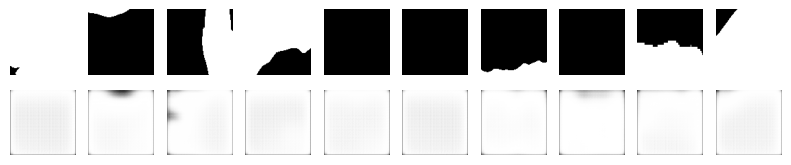

In [27]:
import keras
random_test = np.random.randint(test_x.shape[0],size=10)
ae_imgs = model.predict(test_x)
plt.figure(figsize=(14,4))
for i, image_idx in enumerate(random_test):
    ax = plt.subplot(4,14,i+1)
    plt.imshow(test_y[image_idx].reshape(96,96) * 255,cmap='gray')
    ax.axis('off')
    ax = plt.subplot(4,14,14+i+1)
    plt.imshow(ae_imgs[image_idx].reshape(96,96)*255,cmap='gray')
    ax.axis('off')

plt.show()